magpie


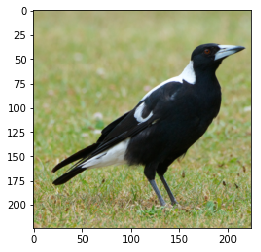

In [13]:
from PIL import Image
from torchvision import transforms
import torch
import torch.nn as nn
from torchvision.models import resnet50
import json
import torch.optim as optim


# read the image, resize to 224 and convert to PyTorch Tensor
img = Image.open("mag.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
img_tensor = preprocess(img)[None,:,:,:]
img_tensor = img_tensor[0:1, 0:3, 0:224, 20:244]
# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(img_tensor[0].numpy().transpose(1,2,0))

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

# form predictions
pred = model(norm(img_tensor))

with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

In [22]:
delta = torch.zeros_like(img_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)
epsilon = 2./255

for t in range(200):
    pred = model(norm(img_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([18])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([340])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 11.980132102966309
10 -12.728450775146484
20 -28.40487289428711
30 -36.83782958984375
40 -38.28064727783203
50 -41.96323776245117
60 -44.2689094543457
70 -45.861328125
80 -46.91466522216797
90 -49.62379455566406
100 -51.58905029296875
110 -50.95278549194336
120 -49.88620376586914
130 -51.387474060058594
140 -52.01991653442383
150 -53.79132080078125
160 -54.29548645019531
170 -52.37071228027344
180 -54.34904479980469
190 -57.24457550048828


In [23]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  zebra
Predicted probability: 0.9999995231628418
